In [1]:
!pip install panda
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [3]:
# analysis_business_analyst.py
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [35]:
# Setup
implementation_date = "2024-03-08"

# Load Data
csat = pd.read_csv("csat_data.csv", index_col="response_date", parse_dates=True)
audit = pd.read_csv("self_audit_data.csv", index_col="date", parse_dates=True)


In [36]:
# ======================================
# 1. Impact Assessment
# ======================================
pre = csat.loc[csat.index < implementation_date, "csat_count"]
post = csat.loc[csat.index >= implementation_date, "csat_count"]

# Normality check
_, p_pre = stats.shapiro(pre)
_, p_post = stats.shapiro(post)

if p_pre > 0.05 and p_post > 0.05:
    t_stat, p_val = stats.ttest_ind(pre, post)
    test_used = "t-test"
else:
    t_stat, p_val = stats.mannwhitneyu(pre, post)
    test_used = "Mann-Whitney U"

print(f"[1] Impact Assessment: {test_used} p={p_val:.4f}")


# ======================================

[1] Impact Assessment: Mann-Whitney U p=0.1871


[2] Behavioral Trends: Regression p-value = 0.5434645520490164
Slope (trend) = 0.0005138693951466262


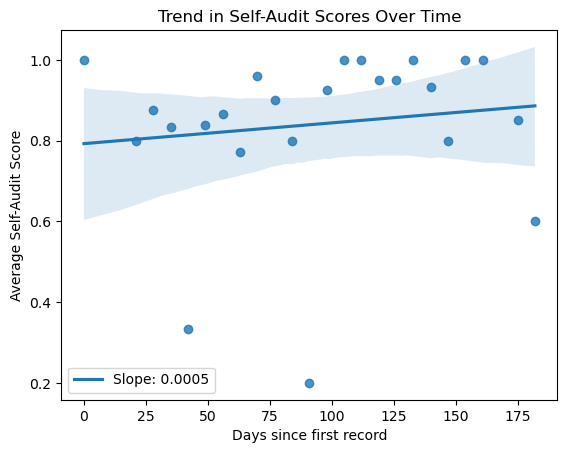

In [41]:
# 2. Behavioral Trends (fixed)
# Using regression instead of t-tests because the question asks for trends over time, not just differences at two points.
# Regression lets us quantify the direction and magnitude of change across the entire time period.

audit["avg_score"] = audit[["professionalism","clarity","empathy","value_guest_time","ability_solve"]].mean(axis=1)
audit_weekly = audit.resample("W")["avg_score"].mean().reset_index()

# Drop NaNs before regression
audit_weekly = audit_weekly.dropna()

# Days since first date for regression
X_days = (audit_weekly["date"] - audit_weekly["date"].min()).dt.days
X = sm.add_constant(X_days)
y = audit_weekly["avg_score"]

model = sm.OLS(y, X).fit()
print("[2] Behavioral Trends: Regression p-value =", model.pvalues.iloc[1])
print("Slope (trend) =", model.params.iloc[1])

# Plot with regression line showing slope
sns.regplot(
    x=X_days,
    y="avg_score",
    data=audit_weekly,
    line_kws={"label":f"Slope: {model.params.iloc[1]:.4f}"}
)
plt.legend()
plt.title("Trend in Self-Audit Scores Over Time")
plt.xlabel("Days since first record")
plt.ylabel("Average Self-Audit Score")
plt.show()

In [33]:
# 3. Tenure vs. Proficiency
# ======================================
tenure_map = csat[["agent_name", "Tenure_Bucket"]].drop_duplicates()
audit_tenure = audit.merge(tenure_map, on="agent_name", how="left")

agent_scores = audit_tenure.groupby("agent_name")["avg_score"].mean()
tenure_scores = audit_tenure.groupby("agent_name")["Tenure_Bucket"].first()

# Encode tenure to numeric for correlation
tenure_encoded = tenure_scores.astype("category").cat.codes
corr, p_corr = stats.spearmanr(tenure_encoded, agent_scores)
print(f"[3] Tenure vs Proficiency: Spearman correlation={corr:.3f}, p={p_corr:.4f}")

# ======================================

[3] Tenure vs Proficiency: Spearman correlation=-0.137, p=0.4313


[4] Self-Perception vs Reality: Pearson correlation=-0.300, p=0.0903


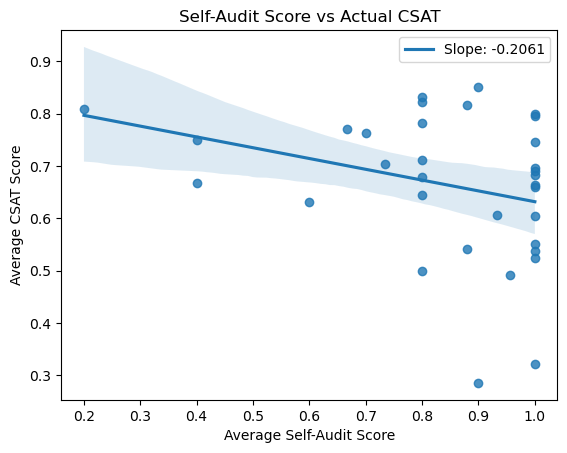

In [42]:
# ======================================
# 4. Self-Perception vs. Reality (with slope line)
# ======================================
agent_self = audit.groupby("agent_name")["avg_score"].mean()
agent_csat = csat.groupby("agent_name")["csat_count"].mean()

merged = pd.DataFrame({
    "self_score": agent_self,
    "csat_score": agent_csat
}).dropna()

# Pearson correlation
corr_sr, p_sr = stats.pearsonr(merged["self_score"], merged["csat_score"])
print(f"[4] Self-Perception vs Reality: Pearson correlation={corr_sr:.3f}, p={p_sr:.4f}")

# Regression for slope
X = sm.add_constant(merged["self_score"])
y = merged["csat_score"]
model = sm.OLS(y, X).fit()
slope = model.params.iloc[1]

# Scatter + regression line
sns.regplot(
    x="self_score",
    y="csat_score",
    data=merged,
    line_kws={"label": f"Slope: {slope:.4f}"}
)
plt.legend()
plt.title("Self-Audit Score vs Actual CSAT")
plt.xlabel("Average Self-Audit Score")
plt.ylabel("Average CSAT Score")
plt.show()

In [10]:
# 5. Pre vs Post Comparison
# ======================================
print(f"[5] Pre vs Post: {test_used} statistic={t_stat:.3f}, p={p_val:.4f}")

# ======================================

[5] Pre vs Post: Mann-Whitney U statistic=1651693.500, p=0.1871


In [12]:
# 6. Areas for Improvement
# ======================================
behavior_cols = ["professionalism","clarity","empathy","value_guest_time","ability_solve"]
improvement_opportunities = {}
for col in behavior_cols:
    col_mean = audit.groupby("agent_name")[col].mean()
    merged_b = pd.DataFrame({col: col_mean, "csat_score": agent_csat}).dropna()
    corr_b, _ = stats.pearsonr(merged_b[col], merged_b["csat_score"])
    improvement_opportunities[col] = corr_b

low_corr_behaviors = sorted(improvement_opportunities.items(), key=lambda x: abs(x[1]))[:3]
print("[6] Areas for Improvement:", low_corr_behaviors)

# ======================================

[6] Areas for Improvement: [('empathy', -0.17007438002329023), ('professionalism', -0.19150013796622126), ('value_guest_time', -0.21175552625295932)]


In [ ]:
print("""
[7] Recommendations:
- Increase self-audit coverage across all agents for a more representative sample.
- Align self-audit scoring scale with CSAT to reduce bias.
- Collect post-interaction customer feedback linked directly to the same audited interaction.
""")